# 1  Скачивание данных

## Базовая настройка проекта

In [1]:
import numpy as np
from pyquery import PyQuery as pq
from matplotlib import pylab as plt

%matplotlib inline
%config InlineBackend.figure_format = "svg"
%config InlineBackend.close_figures = True

## Скачиваем данные

In [2]:
with open("data_txt/section1end.txt", 'r') as data_x_txt:
    data = data_x_txt.read()
    data = data.split()
    detrend_phi = np.array(data[1::2]).astype(np.float32)
    filtred_date = np.array(data[0::2]).astype(np.float32)
    print(filtred_date.shape, detrend_phi.shape)
with open("data_txt/section1end_nofil.txt", 'r') as data_x_txt:
    data = data_x_txt.read()
    data = data.split()
    phi = np.array(data[1::2]).astype(np.float32)
    print(phi.shape)

(13514,) (13514,)
(13514,)


# 2 Построим модель перехода

## Начало

Переход произошел примерно в 2007 году. Поэтому для построения модели отбросим из начального $\phi(t)$ (с линейной частью) все позднее 2007г.

### Находим и визуализируем точку перехода

In [3]:
max_peak = np.max(detrend_phi)
max_peak_i = np.where(detrend_phi == max_peak)[0][0]
max_peak_date = filtred_date[max_peak_i]

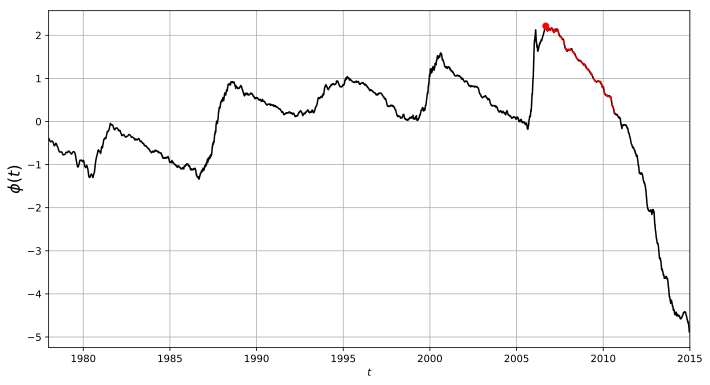

In [4]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$", fontsize=16)
plt.xlabel("$t$")
plt.xlim(filtred_date[0], filtred_date[-1])
plt.plot(filtred_date, detrend_phi, color="black", label="$\phi(t)$")
plt.plot(filtred_date[max_peak_i:max_peak_i + 365 * 4], detrend_phi[max_peak_i:max_peak_i + 365 * 4], "r--")
plt.plot(max_peak_date, max_peak, "o" ,c="red")
plt.savefig("figures/pres.eps", format="eps", bbox_inches='tight')
plt.show()

### Вырезаем данные до перехода

In [5]:
model_date = filtred_date[:max_peak_i]
model_phi = phi[:max_peak_i]

### Удалим линейную часть из $\phi(t)$

In [6]:
model_A = np.vstack([model_date, np.ones(len(model_date))]).T
model_a, model_b = np.linalg.lstsq(model_A, model_phi, rcond=None)[0]
print("a = {}, b = {}".format(model_a, model_b))
model_trend = model_a * model_date + model_b

a = -5.234587049937571, b = 10353.679664412059


In [7]:
detrend_model_phi = model_phi - model_trend

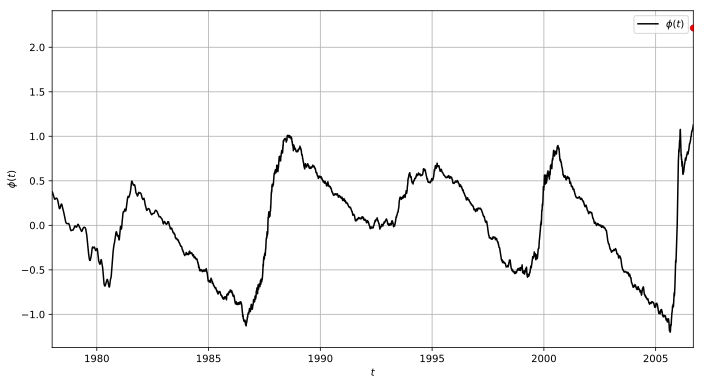

In [8]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(model_date[0], model_date[-1])
plt.plot(model_date, detrend_model_phi, color="black", label="$\phi(t)$")
plt.scatter(max_peak_date, max_peak, c="r")
plt.savefig("./figures/section2/depolar.eps", format="eps" ,bbox_inches='tight')
plt.legend()
plt.show()

## Отфильруем сигнала, удалив частоты > 1 года

### Выгружаем нефильтр-е данные

In [9]:
with open("data_txt/model_phi_1.txt", 'w') as datatxt:
    for i in range(len(model_date)) :
        print(model_date[i], '\t', detrend_model_phi[i], file=datatxt)

### Загружем отфильрованные данные

In [10]:
with open("data_txt/fmphi.txt", 'r') as data_txt:
    data = data_txt.read()
    data = data.split()
    filtred_model_phi = np.array(data[1::2]).astype(np.float32)
    print(filtred_model_phi.shape, model_date.shape)

(10477,) (10477,)


### Выделим шум

In [11]:
model_noise = detrend_model_phi - filtred_model_phi

### Построим полученные данные

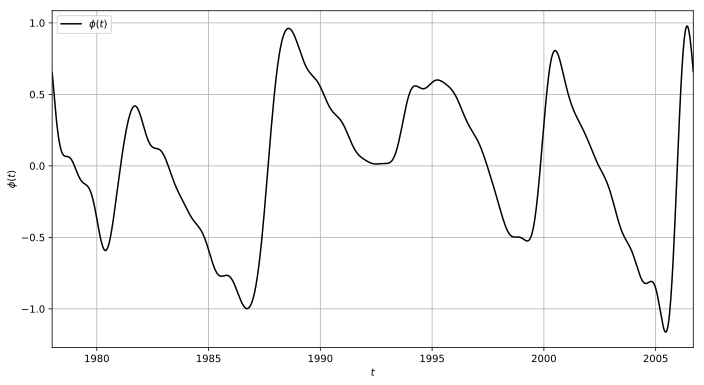

In [12]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(model_date[0], model_date[-1])
plt.plot(model_date, filtred_model_phi, color="black", label="$\phi(t)$")
plt.savefig("./figures/section2/filphi.eps", format="eps" ,bbox_inches='tight')
plt.legend()
plt.show()

## Будем строить модель как отражение существ. данных и смещение на 1 - N

In [13]:
N = 0.85
bayes = 1 - N
bayes

0.15000000000000002

### Возможные точки с которых можно отражать данные

In [14]:
print(model_date[6500], model_date[7500])
inte = 6500, 7800
hi =  inte[1] - inte[0]
b = 1500
inte_1 = b, b + hi + 400
d = 3900
inte_2 = d, d + hi + 200

1995.7988 1998.5366


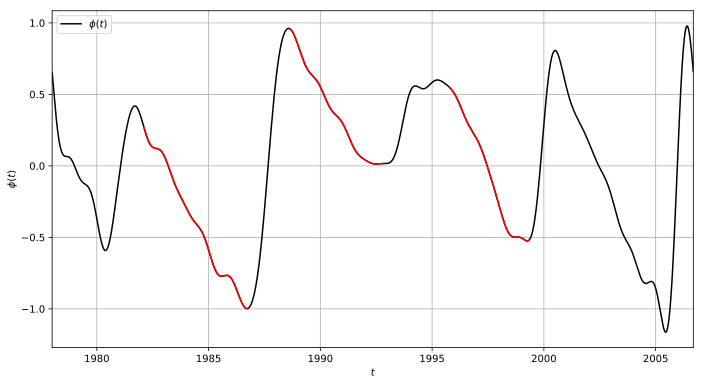

In [15]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(model_date[0], model_date[-1])
plt.plot(model_date, filtred_model_phi, color="black", label="$\phi(t)$")
plt.plot(model_date[inte[0]: inte[1]], filtred_model_phi[inte[0] : inte[1]], color="r")
plt.plot(model_date[inte_1[0]: inte_1[1]], filtred_model_phi[inte_1[0] : inte_1[1]], color="r")
plt.plot(model_date[inte_2[0]: inte_2[1]], filtred_model_phi[inte_2[0] : inte_2[1]], color="r")

plt.savefig("./figures/section2/phiselected.eps", format="eps" ,bbox_inches='tight')
plt.legend()
plt.show()

### Функция для создания новой модели

In [16]:
def newmodel(repoint, old_date, old_phi, df1=0, df2=0, inte=0, lel=0):
    new_date1 = old_date[:repoint]
    new_date2 = old_date[repoint:]
    tmp_ = new_date2.size
    new_phi1 = old_phi[:repoint]
    if lel:
        tmp_ = lel
    new_phi2 = -1 *old_phi[repoint:] - (1 - N) * (old_date[:tmp_] -  new_date1[0]) * np.pi * 2
    new_phi2 += (new_phi1[-1] - new_phi2[0])
    
#     print(new_date1.size, new_date2.size, new_phi1.size, new_phi2.size )
    
    if df1:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,1)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(old_date[0], old_date[-1])
        plt.plot(new_date1, new_phi1, color="black", label="$\phi(t)$")
        plt.plot(new_date2, new_phi2, color="red", label="$\phi(t)$")
        if df2:
            plt.subplot(3,1,2)
            plt.grid(True)
            plt.ylabel("$\phi(t)$")
            plt.xlabel("$t$")
            plt.xlim(old_date[0], old_date[-1])
            plt.plot(old_date, old_phi, color="black", label="$\phi(t)$")
            plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="y")
            plt.scatter(old_date[repoint], old_phi[repoint], c="blue")
            plt.legend()
        plt.savefig("./figures/section2/model.eps", format="eps" ,bbox_inches='tight')
        plt.legend()
        plt.show()
    
    return np.concatenate([new_date1, new_date2]), np.concatenate([new_phi1, new_phi2])

1997.1677


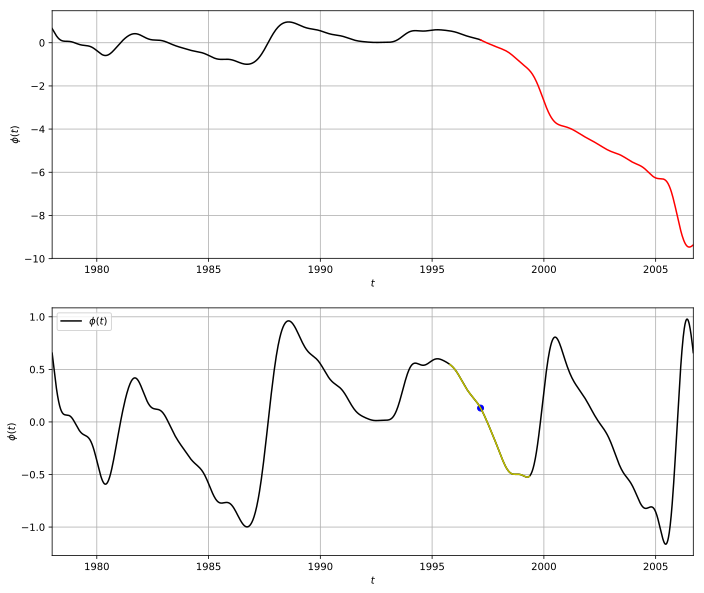

In [17]:
repoint = 7000
print(model_date[repoint])
mod_t1, mod_phi1 = newmodel(repoint, model_date, filtred_model_phi, 1, 1, inte)

### Функция поиска точки частотного перехода

In [18]:
def find_max_delta(repoint, t, phi, length, h):
    new_t = t[:repoint]
    new_p = phi[:repoint]
    n = (new_t.size - length) // h
    a = []
    b = []
    res = []
    delta = []
    T = []
    PHI = []
    
    for i in range(n):
        t_ = np.array(new_t[i * h : length + i * h])
        T.append(t_)
        phi_ = np.array(new_p[i * h : length + i * h])
        PHI.append(phi_)

        A_ = np.vstack([T[i], np.ones(len(T[i]))]).T
        a_, b_ = np.linalg.lstsq(A_, PHI[i], rcond=None)[0]

        a.append(a_)
        b.append(b_)

        res_ = a_ * T[i] + b_

        res.append(res_)
        delta.append(a_)
        
    return np.min(delta)

### Функция поиска точки перехода

In [19]:
def find_ppoint(repoint, t, phi, length, h,
                delta, df1=0, df2=0, old_date=None, 
                old_phi=None,  inte = 0, df3=0, df4=0, df5=0):
    t_ex_ch = t[repoint]
    a = []
    b = []
    res = []
    
    n = (t.size - length) // h
    mmin = 5
    T = []
    PHI = []
    
    for i in range(n):
        t_ = np.array(t[i * h : length + i * h])
        T.append(t_)
        phi_ = np.array(phi[i * h : length + i * h])
        PHI.append(phi_)

        A_ = np.vstack([T[i], np.ones(len(T[i]))]).T
        a_, b_ = np.linalg.lstsq(A_, PHI[i], rcond=None)[0]

        a.append(a_)
        b.append(b_)

        res_ = a_ * T[i] + b_

        res.append(res_)
        if a[i] < -1 * np.abs(delta):
            t_ch = t[length + i * h] 
            ind_ch = length + i * h
            mmin = t_ch - t_ex_ch
            mmin_i = i
            
            break
#             if t_ch - t_ex_ch < mmin:
#                 mmin = t_ch - t_ex_ch
#                 mmin_i = i
          
    print("Точка перехода известная: %.4f"%t_ex_ch)
    print("Точка перехода alg: %.4f"%t[length + mmin_i * h])
    print("отклонение от точки перехода {}".format(mmin))
    print("\n")
    
    if df1:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,1)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(t[0], t[-1])
        plt.plot(t, phi, color="black", label="$\phi(t)$", alpha=0.2)
#         plt.plot(T[mmin_i], res[mmin_i], "red")
        plt.scatter(t[repoint], phi[repoint], c="b", alpha=1)
        plt.scatter(t[length + mmin_i * h], phi[length + mmin_i * h], c="gold", alpha=1)
        if df2:
            plt.subplot(3,1,2)
            plt.grid(True)
            plt.ylabel("$\phi(t)$")
            plt.xlabel("$t$")
            plt.xlim(old_date[0], old_date[-1])
            plt.plot(old_date, old_phi, color="black", label="$\phi(t)$", alpha=0.2)
            plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="r")
            plt.scatter(old_date[repoint], old_phi[repoint], c="blue")
            plt.scatter(old_date[length + mmin_i * h], old_phi[length + mmin_i * h], c="gold", alpha=1)
            plt.legend()
    if df3:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,2)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(old_date[0], old_date[-1])
        plt.plot(old_date, old_phi, color="black", label="$\phi(t)$", alpha=0.2)
        plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="r")
        plt.scatter(old_date[repoint], old_phi[repoint], c="blue")
        plt.scatter(old_date[length + mmin_i * h], old_phi[length + mmin_i * h], c="gold", alpha=1)
    if df4:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,2)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(old_date[0], old_date[-1])
        plt.plot(t, phi, color="gray", label="$\phi(t)$")
        for i in range(0, len(T), 450):
            plt.plot(T[i], res[i], "red")
    if df5:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,2)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(old_date[0], old_date[-1])
        plt.plot(old_date, old_phi, color="gray", label="$\phi(t)$")
#         plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="r")
        plt.plot(old_date[repoint], old_phi[repoint], "o", c="r", label="$Точка смены частотного режима (Фактическая)$")
        plt.plot(old_date[length + mmin_i * h], old_phi[length + mmin_i * h], "o", c="green", label="$Точка смены частотного режима (Алгоритм)$")
        plt.legend()
    
    return t_ch - t_ex_ch, repoint, inte[-1] - t_ch

### Находим точку перехода

In [20]:

length = 365 * 4
h = 1

In [21]:
delta1 = find_max_delta(repoint, mod_t1, mod_phi1, length, h)
print(delta1)

-0.30631351250525213


Точка перехода известная: 1997.1677
Точка перехода alg: 1998.6708
отклонение от точки перехода 1.5030517578125




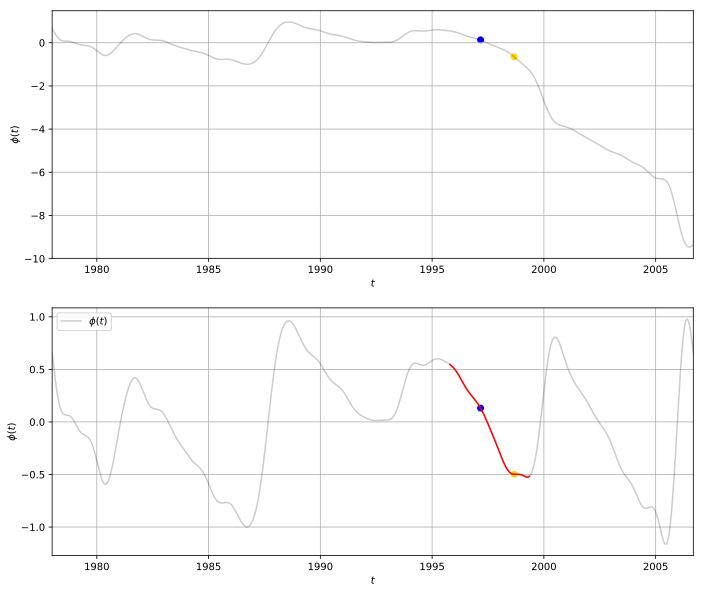

In [22]:
res1 = find_ppoint(repoint, mod_t1, mod_phi1, length, h, delta1, 1, 1, model_date, filtred_model_phi, inte, 0, 0)

plt.savefig("./figures/section2/result_asd.eps", format="eps" ,bbox_inches='tight')
plt.show()

In [23]:
365 * 1.5

547.5

## Добваим шумы

In [24]:
mod_phi1 += model_noise

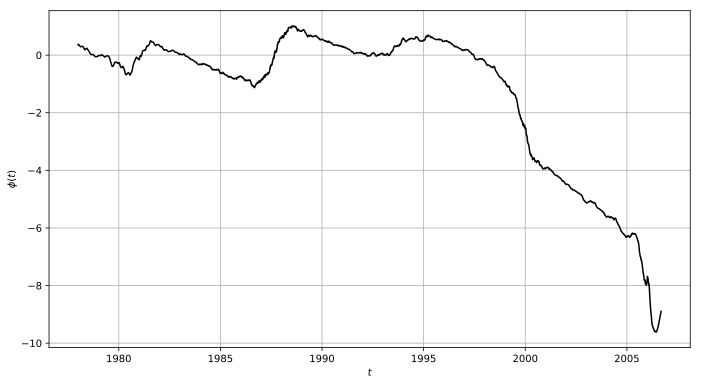

In [25]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
# plt.xlim(model_date[0], model_date[-1])
plt.plot(model_date, mod_phi1, color="black", label="$\phi(t)$")
# plt.plot(model_date[inte[0]: inte[1]], filtred_model_phi[inte[0] : inte[1]], color="r")
plt.show()

In [26]:
delta1 = find_max_delta(repoint, mod_t1, mod_phi1, length, h)
print(delta1)

-0.3046700570294847


Точка перехода известная: 1997.1677
Точка перехода alg: 1998.6790
отклонение от точки перехода 1.51123046875




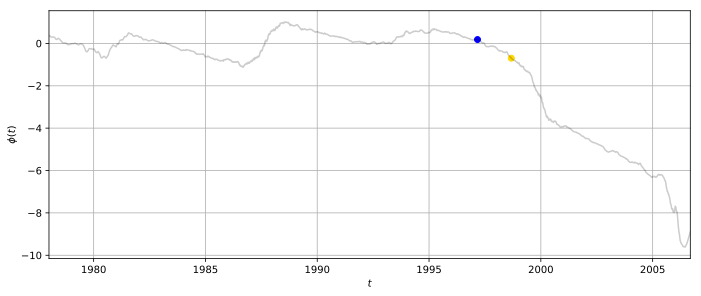

In [27]:
res1 = find_ppoint(repoint, mod_t1, mod_phi1, length, h, delta1, 1, 0, model_date, filtred_model_phi, inte, 0)

In [28]:
with open("data_txt/noise.txt", "w") as txt:
    for i in range(len(model_date)) :
        print(model_date[i], '\t', model_noise[i], file=txt)

# presentation 

In [29]:
def find_ppoint(repoint, t, phi, length, h,
                delta, df1=0, df2=0, old_date=None, 
                old_phi=None,  inte = 0, df3=0, df4=0, df5=0):
    t_ex_ch = t[repoint]
    a = []
    b = []
    res = []
    
    n = (t.size - length) // h
    mmin = 5
    T = []
    PHI = []
    
    for i in range(n):
        t_ = np.array(t[i * h : length + i * h])
        T.append(t_)
        phi_ = np.array(phi[i * h : length + i * h])
        PHI.append(phi_)

        A_ = np.vstack([T[i], np.ones(len(T[i]))]).T
        a_, b_ = np.linalg.lstsq(A_, PHI[i], rcond=None)[0]

        a.append(a_)
        b.append(b_)

        res_ = a_ * T[i] + b_

        res.append(res_)
        if a[i] < -1 * np.abs(delta):
            t_ch = t[length + i * h] 
            ind_ch = length + i * h
            mmin = t_ch - t_ex_ch
            mmin_i = i
            
            break
#             if t_ch - t_ex_ch < mmin:
#                 mmin = t_ch - t_ex_ch
#                 mmin_i = i
          
    print("Точка перехода известная: %.4f"%t_ex_ch)
    print("Точка перехода alg: %.4f"%t[length + mmin_i * h])
    print("отклонение от точки перехода {}".format(mmin))
    print("\n")
    
    if df1:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,1)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(t[0], t[-1])
        plt.plot(t, phi, color="black", label="$\phi(t)$", alpha=0.2)
#         plt.plot(T[mmin_i], res[mmin_i], "red")
        plt.scatter(t[repoint], phi[repoint], c="b", alpha=1)
        plt.scatter(t[length + mmin_i * h], phi[length + mmin_i * h], c="gold", alpha=1)
        if df2:
            plt.subplot(3,1,2)
            plt.grid(True)
            plt.ylabel("$\phi(t)$")
            plt.xlabel("$t$")
            plt.xlim(old_date[0], old_date[-1])
            plt.plot(old_date, old_phi, color="black", label="$\phi(t)$", alpha=0.2)
            plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="r")
            plt.scatter(old_date[repoint], old_phi[repoint], c="blue")
            plt.scatter(old_date[length + mmin_i * h], old_phi[length + mmin_i * h], c="gold", alpha=1)
            plt.legend()
    if df3:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,2)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(old_date[0], old_date[-1])
        plt.plot(old_date, old_phi, color="black", label="$\phi(t)$", alpha=0.2)
        plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="r")
        plt.scatter(old_date[repoint], old_phi[repoint], c="blue")
        plt.scatter(old_date[length + mmin_i * h], old_phi[length + mmin_i * h], c="gold", alpha=1)
    if df4:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,2)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(old_date[0], old_date[-1])
        plt.plot(t, phi, color="gray", label="$\phi(t)$")
        for i in range(0, len(T), 450):
            plt.plot(T[i], res[i], "red")
    if df5:
        plt.figure(figsize=(11.5, 15.5))
        plt.subplot(3,1,2)
        plt.grid(True)
        plt.ylabel("$\phi(t)$")
        plt.xlabel("$t$")
        plt.xlim(old_date[0], old_date[-1])
        plt.plot(old_date, old_phi, color="gray", label="$\phi(t)$")
#         plt.plot(old_date[inte[0]: inte[1]], old_phi[inte[0]: inte[1]], color="r")
        plt.plot(old_date[repoint], old_phi[repoint], "o", c="r", label="Точка смены частотного режима (Предполагаемая)")
        index0f = np.where(old_date == 2009.0253)[0][0]
        index0f -= 365
        plt.plot(old_date[index0f], old_phi[index0f], "o", c="gold", label="Точка смены частотного режима (Реальная)")

        print(index0f)
        plt.plot(old_date[length + mmin_i * h], old_phi[length + mmin_i * h], "o", c="green", label="Точка смены частотного режима (Алгоритм)")
        plt.legend()
        print(old_date[index0f], old_date[length + mmin_i * h], old_date[length + mmin_i * h] - old_date[index0f])
    
    return t_ch - t_ex_ch, repoint, inte[-1] - t_ch

In [30]:
length = 365 * 3

In [31]:
repoint = max_peak_i

In [32]:
delta1 = find_max_delta(repoint, filtred_date, detrend_phi, length, h)
print(delta1)

-0.3357114202081256


Точка перехода известная: 2006.6873
Точка перехода alg: 2009.2745
отклонение от точки перехода 2.5872802734375


10966
2008.026 2009.2745 1.2485352


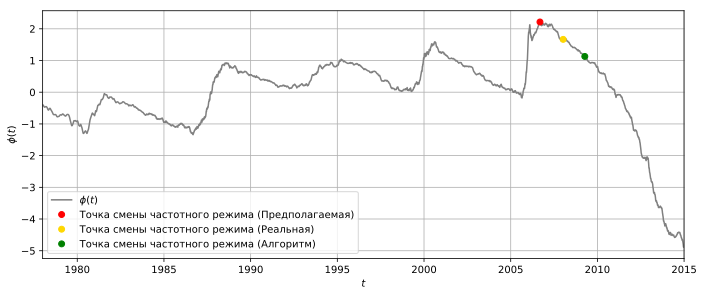

In [33]:
res1 = find_ppoint(repoint, filtred_date, detrend_phi, length, h, delta1, 0, 0, filtred_date, detrend_phi, inte, 0, 0, 1)

plt.savefig("./figures/section2/result_asd_real.eps", format="eps" ,bbox_inches='tight')
plt.show()

1997.1677
Точка перехода известная: 1997.1677
Точка перехода alg: 1998.2683
отклонение от точки перехода 1.1005859375




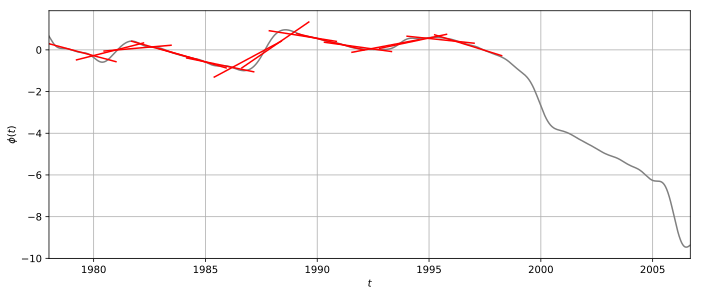

In [34]:
repoint = 7000
print(model_date[repoint])
mod_t1, mod_phi1 = newmodel(repoint, model_date, filtred_model_phi, 0, 0, inte)
res1 = find_ppoint(repoint, mod_t1, mod_phi1, length, h, delta1, 0, 0, model_date, filtred_model_phi, inte, 0, 1)

plt.savefig("./figures/section2/result_asd.eps", format="eps" ,bbox_inches='tight')
plt.show()